<a href="https://colab.research.google.com/github/mc-robinson/polyreg_vs_dnn_experiment/blob/master/Cheng_polyreg_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Input-space distance uncertainty on the Concrete Dataset ##

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# from https://docs.fast.ai/dev/test.html#getting-reproducible-results

import torch
import fastai
from fastai.tabular import *

seed = 13

# python RNG
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
concrete_df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls')
concrete_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [0]:
data_df = concrete_df.iloc[:,:-1]
target_df = concrete_df.iloc[:,-1]

In [5]:
data_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [6]:
target_df.head()

0    79.986111
1    61.887366
2    40.269535
3    41.052780
4    44.296075
Name: Concrete compressive strength(MPa, megapascals) , dtype: float64

In [0]:
# do a 80, 10, 10 split
from sklearn.model_selection import train_test_split

X_train_plus_valid, X_test, y_train_plus_valid, y_test = \
train_test_split(data_df,
                 target_df,
                 test_size=0.1,
                 random_state=13)

X_train, X_valid, y_train, y_valid = \
train_test_split(X_train_plus_valid,
                 y_train_plus_valid,
                 test_size=0.1,
                 random_state=13)

In [0]:
from sklearn.preprocessing import StandardScaler

X_std_scalar = StandardScaler().fit(X_train)
X_train_std = np.array(X_std_scalar.transform(X_train))
X_valid_std = np.array(X_std_scalar.transform(X_valid))
X_test_std = np.array(X_std_scalar.transform(X_test))

In [0]:
# convert to pytorch tensors
X_train, y_train, X_valid, y_valid, X_test, y_test = \
map(
  partial(torch.tensor, dtype=torch.float),
  (X_train_std, np.array(y_train), X_valid_std, np.array(y_valid), X_test_std, np.array(y_test))
)

# construct pytorch datasets
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
test_ds = TensorDataset(X_test, y_test)

# construct fastai databunch
bs = 64
data = DataBunch.create(train_ds, valid_ds, test_ds=test_ds, bs=bs)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn:Optional[nn.Module]=None):
    "`n_in`->bn->dropout->linear(`n_in`,`n_out`)->`actn`"
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

class Simple_DNN(nn.Module):
  def __init__(self, n_in, n_hidden=[512, 512, 512], n_out=1, dropout=0.5):
    super(Simple_DNN, self).__init__()
    
    layers = []
    layers += bn_drop_lin(n_in, n_hidden[0],
                          bn=False, p=0.0,
                          actn=nn.ReLU(inplace=True))
    for i in range(len(n_hidden)-1):
      layers += bn_drop_lin(n_hidden[i], n_hidden[i+1],
                            bn=False, p=dropout,
                            actn=nn.ReLU(inplace=True))
    layers += bn_drop_lin(n_hidden[-1], n_out,
                            bn=False, p=dropout,
                            actn=None)
    
    self.layers = nn.Sequential(*layers)
    
  def forward(self, xb):
    xb = self.layers(xb)
    return xb

In [0]:
learn = Learner(data,
                  Simple_DNN(n_in=data.train_ds.tensors[0].shape[1],
                             n_hidden=[512, 512, 512],
                             n_out=1,
                             dropout=0.5),
                  loss_func=MSELossFlat(),
                  metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


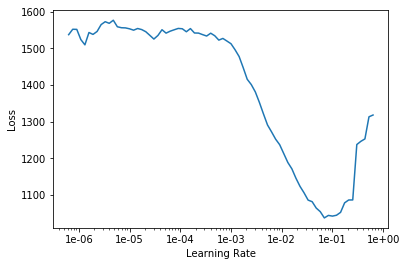

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(100, 5e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,1500.869385,1658.375366,40.694828,-4.480804,00:00
1,1400.768677,1340.696045,36.588207,-3.429149,00:00
2,1171.604248,604.633545,24.564524,-0.993732,00:00
3,900.122070,425.798401,20.621479,-0.407759,00:00
4,728.090393,298.197327,17.257862,0.013782,00:00
5,602.636230,305.333282,17.468786,-0.013112,00:00
6,503.018494,213.829132,14.622591,0.284225,00:00
7,436.793610,247.894699,15.744332,0.173296,00:00
8,378.828125,175.932632,13.247873,0.404035,00:00
9,332.030060,178.106064,13.337935,0.399186,00:00


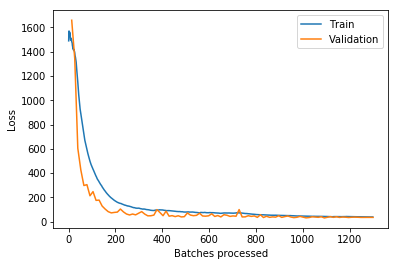

In [14]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


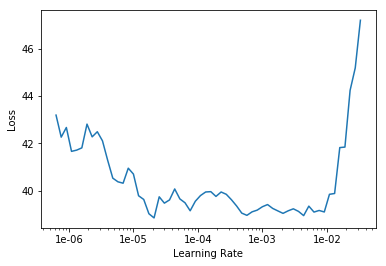

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(50, 5e-05)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,38.455490,35.894352,5.862402,0.873714,00:00
1,38.044590,35.944431,5.866913,0.873547,00:00
2,38.392315,36.161793,5.886469,0.872821,00:00
3,38.330620,36.119213,5.882712,0.872965,00:00
4,38.837322,36.254543,5.894205,0.872499,00:00
5,38.834602,36.415825,5.907947,0.871946,00:00
6,38.575985,36.496761,5.915296,0.871678,00:00
7,38.367104,35.945107,5.866550,0.873536,00:00
8,38.772636,35.483074,5.827348,0.875133,00:00
9,38.428928,36.704346,5.936919,0.871054,00:00


In [0]:
y_pred = np.array(get_preds(learn.model, data.test_dl)[0]).reshape(-1,)
y_true = np.array(data.test_ds.tensors[1]).reshape(-1)

In [0]:
from sklearn import metrics

In [19]:
# R2 
metrics.r2_score(y_true, y_pred)

0.8549465293261959

In [20]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_true, y_pred))

6.290234

In [21]:
# MAE
metrics.mean_absolute_error(y_true, y_pred)

4.490268

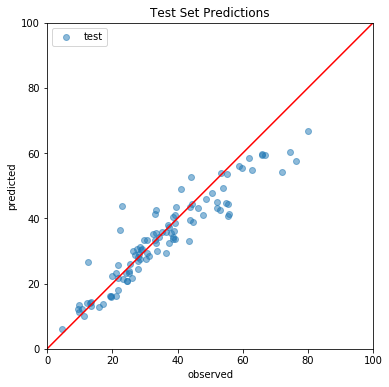

In [22]:
# Plot Test Set Predictions

plt.figure(figsize=(6,6))
# plt.scatter(y_train, train_preds, label='train', alpha=0.5)
plt.scatter(y_true, y_pred, label='test', alpha=0.5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('Test Set Predictions')
plt.xlim(0,100)
plt.ylim(0,100)
plt.gca().set_aspect('equal', adjustable='box')

xvals = np.linspace(0,100,100)
plt.plot(xvals,xvals,'r')
plt.legend();

In [0]:
def pearson_confidence(r, num, interval=0.95):
    """
    BORROWED FROM https://github.com/PatWalters/metk/blob/master/modelevaltoolkit/metk_util.py
    Calculate upper and lower 95% CI for a Pearson r (not R**2)
    Inspired by https://stats.stackexchange.com/questions/18887
    :param r: Pearson's R
    :param num: number of data points
    :param interval: confidence interval (0-1.0)
    :return: lower bound, upper bound
    """
    from scipy.stats import pearsonr
    from scipy.stats import norm
    stderr = 1.0 / math.sqrt(num - 3)
    z_score = norm.ppf(interval)
    delta = z_score * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper

In [29]:
# correlation coefficient (r) on test set
np.sqrt(metrics.r2_score(y_true, y_pred))

0.9246331863642987

In [30]:
# 95% CI for r
pearson_confidence(np.sqrt(metrics.r2_score(y_true, y_pred)), len(y_true))

(0.8967900386490717, 0.9451821142541001)

# Now Time For Multiple Runs

In [0]:
def prepare_data(data_df, target_df):
  
  from sklearn.model_selection import train_test_split
  # don't need a validation set for this procedure 
  X_train, X_test, y_train, y_test = \
  train_test_split(data_df,
                   target_df,
                   test_size=0.2)

  
  from sklearn.preprocessing import StandardScaler
  X_std_scalar = StandardScaler().fit(X_train)
  X_train_std = np.array(X_std_scalar.transform(X_train))
  X_test_std = np.array(X_std_scalar.transform(X_test))
  
  # convert to pytorch tensors
  X_train, y_train, X_test, y_test = \
  map(
    partial(torch.tensor, dtype=torch.float),
    (X_train_std, np.array(y_train), X_test_std, np.array(y_test))
  )

  # construct pytorch datasets
  train_ds = TensorDataset(X_train, y_train)
  test_ds = TensorDataset(X_test, y_test)

  # construct fastai databunch
  # Note that it requires a validation set,
  # So just set it to test_ds
  # Not snooping b/c no hyperparam tuning
  bs = 64
  databunch = DataBunch.create(train_ds, test_ds, test_ds=test_ds,
                          bs=bs, num_workers=1)
  
  return databunch

In [0]:
y_pred_list = []
y_true_list = []
y_unc_list = []

for i in range(10):
  
  data = prepare_data(data_df, target_df)
  
  # use fastai for finding the learning rate and the training 
  # start with no dropout
  learn = Learner(data,
                  Simple_DNN(n_in=data.train_ds.tensors[0].shape[1],
                             n_hidden=[512, 512, 512],
                             n_out=1,
                             dropout=0.5),
                  loss_func=MSELossFlat(),
                  metrics=[root_mean_squared_error, r2_score])
  
  
  learn.fit_one_cycle(125, 5e-03)
  learn.fit_one_cycle(50, 5e-06)
  
  y_pred = np.array(get_preds(learn.model, data.test_dl)[0]).reshape(-1,)
  y_true = np.array(data.test_ds.tensors[1]).reshape(-1,)
  
  y_unc = get_input_space_uncertainty(data.train_ds, data.test_ds)
  
  y_pred_list.append(y_pred)
  y_true_list.append(y_true)
  y_unc_list.append(y_unc)
  
  

In [0]:
def get_average_metrics(y_true_list, y_pred_list):
  
  from sklearn import metrics

  r2_list = []
  mae_list = []
  rmse_list = []

  for i in range(len(y_true_list)):
    r2_list.append(
        metrics.r2_score(y_true_list[i], y_pred_list[i]))
    mae_list.append(
        metrics.mean_absolute_error(y_true_list[i], y_pred_list[i]))
    rmse_list.append(
        np.sqrt(metrics.mean_squared_error(y_true_list[i], y_pred_list[i])))

  print(f'Mean R2 score {np.mean(r2_list)}, sd of {np.std(r2_list)}')
  print(f'Mean MAE score {np.mean(mae_list)}, sd of {np.std(mae_list)}')
  print(f'Mean RMSE score {np.mean(rmse_list)}, sd of {np.std(rmse_list)}')
  

In [0]:
get_average_metrics(y_true_list, y_pred_list)

Mean R2 score 0.8970248399819034, sd of 0.01769153111187187
Mean MAE score 3.8655261993408203, sd of 0.26582813262939453
Mean RMSE score 5.223421573638916, sd of 0.4020664393901825


In [0]:
np.sqrt(0.897)

0.9471008394041259

### The average correlation reported in the paper for NN were 0.608 and 0.546 -- we are getting 0.947! This is also better than the result they report for polyreg (0.869)

### I am really confused